# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
from collections import defaultdict


%matplotlib inline


In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
#get shape
df.shape

(45993, 3)

In [5]:
#get column types
df.dtypes

article_id    float64
title          object
email          object
dtype: object

In [6]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [7]:
#get shape
df_content.shape

(1056, 5)

In [8]:
#get column types
df_content.dtypes

doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object

In [9]:
#get unique entries in df
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

In [10]:
#get unique entries in df_content
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Looking at the df, each article_id has a corresponding email that has read it. Looking at the number of unique entries in df, we can tell that among the 45993 observations we have 714 unique articles and 5148 unique emails. We can use [pandas.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) to get a count of emails per article or the average user consumption.

In [11]:
# how many users read each article
article_by_user_df = df.groupby(by='article_id', as_index=False).count()
article_by_user_df.head()

,article_id,title,email
0,0.0,14,14
1,2.0,58,58
2,4.0,13,13
3,8.0,85,85
4,9.0,10,10


In [12]:
user_by_article_df = df.groupby(by='email', as_index=False).count()
user_by_article_df.head()

,email,article_id,title
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2,2


In [13]:
user_article = user_by_article_df['article_id'].tolist()
user_article_median = np.median(user_article)

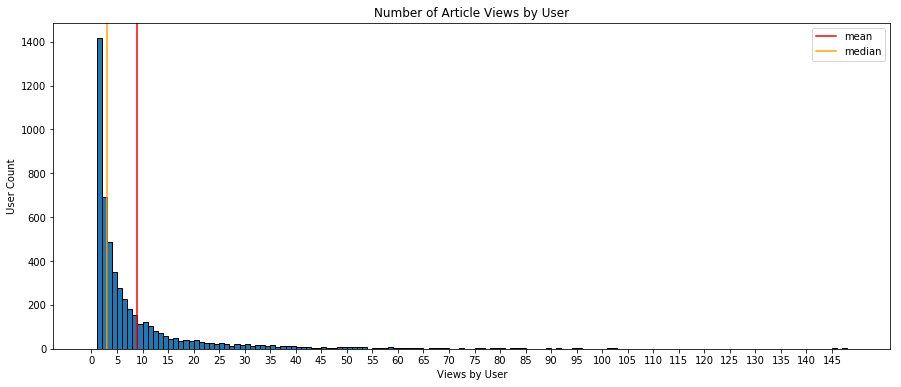

In [14]:
plt.figure(figsize=(15,6))
plt.hist(user_article, bins=np.arange(0,150,1), ec='black')
plt.xticks(np.arange(0,150,5))
plt.axvline(x=np.mean(user_article), label='mean', color='red')
plt.axvline(x=np.median(user_article), label='median', color='orange')
plt.xlabel('Views by User')
plt.ylabel('User Count')
plt.title('Number of Article Views by User')
plt.legend()
plt.savefig('plots/user_article_hist.png')
plt.show()

In [15]:
# Fill in the median and maximum number of user_article interactios below

median_val = user_article_median # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = max(user_article)# The maximum number of user-article interactions by any 1 user is ______.

print('50% of individuals interact with {:.1f} number of articles or fewer.'.format(median_val))
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [16]:
# Find and explore duplicate articles
#sort by article_id for pairwise comparison
df_content[df_content['article_id'].duplicated(keep=False)].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


We notice that duplicates are at most one, the doc_full_name is the same, however the doc_description differs between the two. We decide to drop the duplicate article ids and keep only the first.

In [17]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [18]:
# The number of unique articles that have at least one interaction
unique_articles = article_by_user_df[article_by_user_df['email']>0].shape[0]
unique_articles

714

In [19]:
# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()
total_articles

1051

In [20]:
# The number of unique users
unique_users = df['email'].nunique()
unique_users

5148

In [21]:
# The number of user-article interactions
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = article_by_user_df.loc[article_by_user_df['email'].idxmax()]['article_id'].astype(str)
most_viewed_article_id

'1429.0'

In [23]:
# The most viewed article in the dataset was viewed how many times?
max_views = article_by_user_df.loc[article_by_user_df['email'].idxmax()]['email']
max_views

937.0

In [24]:
#map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### !!! Note !!!
The function above assumes that the first user has an id of 0. In the functions below, we must keep note of that if we use any kind of indexing. <br>
We also have to pay attention to [global and local variables](https://docs.python.org/3/faq/programming.html#what-are-the-rules-for-local-and-global-variables-in-python) that we call inside the function.

In [25]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [26]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    #group articles by how many emails interected with them
    article_by_user = df.groupby(by='article_id', as_index=False).count()
    
    #order by most interactions
    article_by_user = article_by_user.sort_values(by=['user_id'], ascending=False)
    
    #get list of articles now sorted
    
    top_articles= article_by_user['article_id'].tolist()
    
    # Return the top article titles from df (not df_content)
    return top_articles[0:n]


In [27]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #get top article_id
    
    top_ids = get_top_article_ids(n, df)
    
    #get ids inside top id, get the title, make a set for unique entries, then make a list
    top_articles = list(set(df[df['article_id'].isin(top_ids)]['title']))
    
    # Return the top article titles from df (not df_content)
    return top_articles 

In [28]:
print(get_top_articles(10))
print("\n")
print(get_top_article_ids(10))

['analyze energy consumption in buildings', 'visualize car data with brunel', 'insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'healthcare python streaming application demo', 'gosales transactions for logistic regression model', 'finding optimal locations of new store using decision optimization', 'predicting churn with the spss random tree algorithm', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts']


[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [29]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [30]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    #create a deep copy before changing anything
    df_dup = df.copy()
    
    #drop duplicate rows because number of occurences does not matter
    df_dup = df_dup.drop_duplicates()
    
    #count occurences of readings by users
    df_count = df_dup.groupby(by=['user_id', 'article_id'], as_index=False).count()
    
    #transform by pivot table
    user_item= df_count.pivot_table(index='user_id', columns='article_id', fill_value=0)
    
    #drop the extra level from titles
    user_item.columns = user_item.columns.droplevel()
    
    # return the user_item matrix 
    return user_item 


user_item = create_user_item_matrix(df)

user_item.head()


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#check shape
user_item.shape

(5149, 714)

In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    #note that the first user id is 1
    
    #create empty array for dot product
    user_id_dots = []
    
    for item in user_item.index.tolist():
        user_id_dots.append(np.dot(user_item.iloc[user_id,:], user_item.iloc[item-1,:]))

    # sort by similarity
    # create list of just the ids
    user_id_dots  = np.array(user_id_dots)
    most_similar_users = user_id_dots.argsort()[::-1]
   
    # remove the own user's id
    most_similar_users = most_similar_users[1:]
    
    # return a list of the users in order from most to least similar
    return most_similar_users 
        

In [34]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3763   48   97 3696    9 2981   20 3781  289 4784]
The 5 most similar users to user 3933 are: [  48  125 2741 1061 4392]
The 3 most similar users to user 46 are: [ 119 3418 2434]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [35]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    # Return the article names associated with list of article ids
    return article_names 

In [36]:
#copy assertions from down here for early check
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."

In [37]:
def get_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    df - (pandas dataframe) dataframe showing instances of article read by each user
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    #select the user_id row and return non zero indeces
    #note that
    user_row = np.nonzero(user_item.iloc[user_id -1 ,:])
    
    #get the article ids corresponding to indeces & convert to strings
    article_ids = np.array(user_item.columns)[user_row].astype(str)

    article_names = get_article_names(article_ids, df)
    
    # return the ids and names
    return article_ids, article_names 

In [38]:
def user_user_recs(user_id, m=10, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    df - (pandas dataframe) dataframe showing instances of article read by each user
    
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    #get articles already seen by user
    init_articles, init_names = get_user_articles(user_id = user_id, user_item=user_item, df=df) 
    
    #get most similar users
    sim_to_user = find_similar_users(user_id, user_item)
    
    #articles to read
    must_read_ids = []
    must_read_names = []
    
    for sim in sim_to_user:
        ids, titles = get_user_articles(sim)
        
        diff_id = np.setdiff1d(init_articles, ids)
        dff_name = np.setdiff1d(init_names, titles)
        
        must_read_ids.extend(diff_id)
        must_read_names.extend(dff_name)
    
        if len(must_read_names)>10:
            break
            
    recs = must_read_ids[0:m]
    
    return recs

In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['country statistics: life expectancy at birth',
 'tensorflow quick tips',
 'categorize urban density',
 'finding optimal locations of new store using decision optimization',
 'classify tumors with machine learning',
 'access db2 warehouse on cloud and db2 with python',
 'gosales transactions for naive bayes model',
 'predict loan applicant behavior with tensorflow neural networking',
 'putting a human face on machine learning',
 'apache spark lab, part 1: basic concepts']

In [40]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [41]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    #lists to store values
    user_id_dots = []
    user_id_clicks = []
    
    #iterate over every user
    for item in user_item.index:
        user_id_dots.append(np.dot(user_item.iloc[user_id-1,:], user_item.iloc[item-1,:]))
        user_id_clicks.append(user_item.iloc[user_id,:].sum())
        
    #create dataframe    
    neighbors_df = pd.DataFrame({'similarity': user_id_dots, 'num_interactions': user_id_clicks},
                                index=user_item.index)
    #sort by dot product then by total clicks
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    #remove the top row since user is msot similar to himself
    neighbors_df = neighbors_df.iloc[1:,:]
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [42]:
#get sample
neighbors_df = get_top_sorted_users(10, df=df, user_item=user_item)
neighbors_df.head()

,similarity,num_interactions
user_id,,
3354,17,30
49,15,30
3697,15,30
98,14,30
3764,14,30


In [43]:
def user_user_recs_part2(user_id, m=10, neighbors_df = neighbors_df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    neighbors_df- (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    init_articles, init_names = get_user_articles(user_id = user_id, user_item=user_item, df=df)
    
    #articles to read
    must_read_ids = []
    must_read_names = []    

    for sim in neighbors_df.index:
        ids, titles = get_user_articles(user_id = sim, user_item=user_item, df=df)

        diff_id = np.setdiff1d(init_articles, ids)
        dff_name = np.setdiff1d(init_names, titles)

        must_read_ids.extend(diff_id)
        must_read_names.extend(dff_name)

        if len(must_read_names)>m:
            break

    recs = must_read_ids[0:m]
    rec_names = must_read_names[0:m] 

    
    
    return recs, rec_names

In [44]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1320.0', '232.0', '844.0', '1320.0', '232.0', '844.0', '1320.0', '232.0', '844.0', '1320.0']

The top 10 recommendations for user 20 are the following article names:
['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery', 'use the cloudant-spark connector in python notebook', 'housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery', 'use the cloudant-spark connector in python notebook', 'housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery', 'use the cloudant-spark connector in python notebook', 'housing (2015): united states demographic measures']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [45]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1
user1_most_sim =  get_top_sorted_users(1, df=df, user_item=user_item).index[0]
print(user1_most_sim)

3933


In [46]:
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).index[9]
print(user131_10th_sim)

242


In [47]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Given a new user with zero prior history, we have no means to compare him with our current users. Therefore any methods that uses a dot product will not be useful. Therefore it is probably best to propose what is already popular with the majority of users and hope that the most read articles are in fact the most relevant articles for most new users.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [48]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
#to match data type in assertion below
new_user_recs = [str(x) for x in new_user_recs]

In [49]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [50]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [52]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [53]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [54]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix)

#### Answer
[SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) is valid to use here because every entry in our matrix is in the field of real numbers. If any value is missing then our algorithm fails to converge and we may need to use [FunkSVD](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)).

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

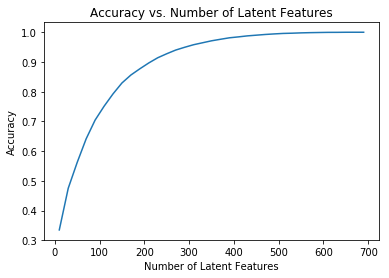

In [55]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.savefig('plots/acc_latent_trial.png')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [56]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train (pandas dataframe) - training dataframe
    df_test (pandas dataframe)- test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [57]:
user_item_train.head(3)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [58]:
user_item_test.head(3)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [59]:
#get users in test set and in training set
common_users_test = list(set(test_idx) & set(user_item_train.index))
print("The number of common users between train and test sets is {}".format(len(common_users_test)))

The number of common users between train and test sets is 20


In [60]:
not_in_test = user_item_test.shape[0] - len(common_users_test)
print("The amount of users we can't predict for is {}".format(not_in_test))

The amount of users we can't predict for is 662


In [61]:
#alternatively we can use the pandas columns.intersection method
common_articles = user_item_train.columns.intersection(test_arts)
print("The number of common articles between train and test sets is {}".format(len(common_articles)))

The number of common articles between train and test sets is 574


In [62]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [63]:
# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

### Recap

When we use SVD we aim to get:
- U: a unitary matrix of shape (n x k) where n is the number of users and k the number of latent feaures 
- Sigma: a diagonal matrix of shape (k x k) where k is the number of latent features and with non-negative real numbers on the diagonal
- V*: a unitary matrix of shape (k x m) where k is the number of latent features and k is the number of articles

<br>
The asterisk (*) here means conjugate transpose

In [64]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [65]:
#only predict on items we can predict for
train_common_idx = user_item_train.index.isin(test_idx)
train_common_col = user_item_train.columns.isin(test_arts)

#extract relevant rows and columns 
u_test = u_train[train_common_idx, :]
vt_test = vt_train[:, train_common_col]

In [66]:
#check u_test shape
u_test.shape

(20, 4487)

In [67]:
#check vt_test shape
vt_test.shape

(714, 574)

In [68]:
#do similar to user_item_test
user_item_test = user_item_test.loc[common_users_test]

In [69]:
def make_pred(u_train, s_train, vt_train, k=10):
    '''
    INPUT:
    u_train (numpy array) - The left-singular vectors of a matrix M
    s_train (numpy array) - The non-zero singular values of a matrix M
    vt_train (numpy array) - The right-singular vectors of a matrix M
    k (integer) - the number of latent features
    
    OUTPUT:
    train_pred - a prediction for the user_item interaction matrix
    
    '''
    
    #trim inputs to fit number of latent features
    u_train_k = u_train[:, :k]
    s_train_k = np.diag(s_train[:k])
    vt_train_k = vt_train[:k, :]
    
    
    #make prediction
    pred = np.dot(np.dot(u_train_k, s_train_k), vt_train_k)
    #round to nearest decimal
    pred = np.around(pred)
    
    return pred

In [70]:
#redefine range of latent features
num_latent_feats = np.arange(10,700+10,20)

#store errors
sse_error_test = []
sse_eror_train = []

#iterate over values of k and store error
for k in num_latent_feats:
    train_pred = make_pred(u_train, s_train, vt_train, k)
    test_pred = make_pred(u_test, s_train, vt_test, k)
    
    #record difference between actual and predicted
    delta_train = np.subtract(user_item_train, train_pred)
    delta_test = np.subtract(user_item_test, test_pred)
    
    #square everything and compute error
    error_test = np.sum(np.sum(np.square(delta_train)))
    eror_train = np.sum(np.sum(np.square(delta_test)))
    
    #track the errors
    sse_eror_train.append(eror_train)
    sse_error_test.append(error_test)


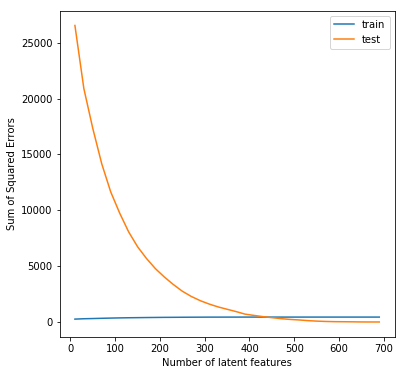

In [71]:
plt.figure(figsize=(6,6))
plt.plot(num_latent_feats, sse_eror_train, label='train')
plt.plot(num_latent_feats, sse_error_test, label='test')
plt.xlabel('Number of latent features')
plt.ylabel('Sum of Squared Errors')
plt.legend()
plt.savefig('plots/svd_plot_train_test.png')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Interestingly enough, the error rate for the test data drops quickly whereas it stagnates for the training data. At one point we get diminishing returns, somewhere at ~450 latent features. Beyond that number we are probably overfitting the data. Our model contains certain shortcoming since it does not provide anything new in terms of serendipity for existing users. <br>
One way to see if our recommendation works correctly is with A/B testing. Say for example we have an experimental and a control group. Our null hypothesis is that the user interaction with an article is unaffected by the recommendation engine. Conversly, our alternative hypothesis is that a recommendatio engine drives traffic to articles.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [72]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0